## Part 3: Setting up RAG Example and Validating our Retrieval Pipeline

We are ready for the finale, but let's recap:

- We started with an example dataset of 5000 images
- In the first notebook, we cleaned this up for labelling and used `Llama-3.2-11B` model for labelling
- In the second notebook, we cleaned up some hallucinations of the model and pre-processed the descriptions that were synthetically generated


Step 3 is to setup a RAG pipeline and profit.

We will use [lance-db](https://lancedb.com) since it's open source and Llama and open source go well together 🤝

We also love free API credits and [Together](https://www.together.ai) is hosting 11B model for free. For our final demo, we will use their API and validate the same in this example.

In [12]:
#!pip install lancedb rerankers together -q

### Loading the Dataset and Creating Embeddings

In [21]:
import pandas as pd
import os
from together import Together

os.environ["TOGETHER_API_KEY"] = ""
client = Together(api_key=os.environ.get('TOGETHER_API_KEY'))

df = pd.read_csv("./MM-Demo/final_balanced_sample_dataset.csv")

In [22]:
df.head()

,Filename,Title,Size,Gender,Description,Category,Type
0,d7ed1d64-2c65-427f-9ae4-eb4aaa3e2389.jpg,Stylish and Trendy Tank Top with Celestial Design,M,F,This white tank top is a stylish and trendy pi...,Tops,Casual
1,5c1b7a77-1fa3-4af8-9722-cd38e45d89da.jpg,Classic White Sweatshirt,M,F,This classic white sweatshirt is a timeless pi...,Tops,Casual
2,b2e084c7-e3a0-4182-8671-b908544a7cf2.jpg,Grey T-shirt,M,Unisex,"This is a short-sleeved, crew neck t-shirt tha...",T-Shirt,Casual
3,87846aa9-86cc-404a-af2c-7e8fe941081d.jpg,Long-Sleeved V-Neck Shirt,L,U,"A long-sleeved, V-neck shirt with a solid purp...",Tops,Casual
4,04fa06fb-d71a-4293-9804-fe799375a682.jpg,Silver Metallic Buckle Sandals,L,F,These silver metallic buckle sandals feature a...,Shoes,Casual


In [24]:
df["Description"][0]

'This white tank top is a stylish and trendy piece of clothing that features a captivating celestial design. The design showcases a mesmerizing array of stars, planets, and moons in black and white, creating a visually appealing and eye-catching pattern. The tank top has a relaxed fit with a round neckline and sleeveless design, making it a comfortable and versatile piece that can be worn on its own or layered under a cardigan or jacket. Perfect for a casual day out or a night on the town, this tank top is a must-have for any fashion-conscious woman.'

#### Creating Embeddings: 

We will define a Schema and use `BAAI/bge-small-en-v1.5` embeddings to create our vector embeddings. This is a first step, we can iterate with more embeddings in our final app later. 

For retrieval, we will embed descriptions of all clothes and use these.

In [37]:
import lancedb
from lancedb.pydantic import LanceModel, Vector
from lancedb.embeddings import get_registry
from lancedb.rerankers import ColbertReranker
from pathlib import Path
from PIL import Image
import pandas as pd

model = get_registry().get("sentence-transformers").create(name="BAAI/bge-small-en-v1.5", device="cuda")

class Schema(LanceModel):
    Filename: str
    Title: str
    Size: str
    Gender: str
    Description: str = model.SourceField()
    Category: str
    Type: str
    vector: Vector(model.ndims()) = model.VectorField()

db = lancedb.connect("~/.lancedb")
tbl = db.create_table(name="clothes", schema=Schema, mode="overwrite")

# Function to clean and convert data types
def clean_data(df):
    # Convert all columns to string type
    for col in df.columns:
        df[col] = df[col].astype(str)
    
    # Remove any rows with NaN values
    df = df.dropna()
    
    return df

# Clean the data
cleaned_df = clean_data(df)

# Convert cleaned DataFrame to list of dictionaries
data = cleaned_df.to_dict('records')

empty_count = len([d for d in data if d.get('Description', '').strip() == ''])
print(f"Number of empty descriptions: {empty_count}")

# automatically generate vectors
tbl.add(data)

tbl.search().to_pandas()

def show_image_from_response(rs):
    names = rs["Filename"].to_list()
    return [Image.open(Path("archive") / "images_compressed" / name) for name in names]

Number of empty descriptions: 0


In [38]:
# automatically generate vectors
tbl.add(data)

In [39]:
tbl.search().to_pandas()

,Filename,Title,Size,Gender,Description,Category,Type,vector
0,d7ed1d64-2c65-427f-9ae4-eb4aaa3e2389.jpg,Stylish and Trendy Tank Top with Celestial Design,M,F,This white tank top is a stylish and trendy pi...,Tops,Casual,"[-0.06355423, 0.02385288, 0.03382446, -0.00212..."
1,5c1b7a77-1fa3-4af8-9722-cd38e45d89da.jpg,Classic White Sweatshirt,M,F,This classic white sweatshirt is a timeless pi...,Tops,Casual,"[-0.011691423, 0.049270794, 0.030319242, -0.02..."
2,b2e084c7-e3a0-4182-8671-b908544a7cf2.jpg,Grey T-shirt,M,Unisex,"This is a short-sleeved, crew neck t-shirt tha...",T-Shirt,Casual,"[-0.010150914, 0.09637642, -0.0012558334, 0.04..."
3,87846aa9-86cc-404a-af2c-7e8fe941081d.jpg,Long-Sleeved V-Neck Shirt,L,U,"A long-sleeved, V-neck shirt with a solid purp...",Tops,Casual,"[-0.058710814, 0.053951632, -0.047531255, 0.03..."
4,04fa06fb-d71a-4293-9804-fe799375a682.jpg,Silver Metallic Buckle Sandals,L,F,These silver metallic buckle sandals feature a...,Shoes,Casual,"[0.0123484805, 0.02398385, 0.059779372, -0.006..."
5,8f576f1a-839d-4fb2-a224-a4700b2d05da.jpg,Orange Long Sleeve T-Shirt,S,U,This long sleeve t-shirt is made of a lightwei...,Tops,Casual,"[-0.016778396, 0.06664105, -0.010597771, 0.052..."
6,e976a8f6-6731-485f-8a9a-2872a5208818.jpg,Green T-Shirt,L,M,The green t-shirt is a relaxed fit with a V-ne...,Tops,Casual,"[0.015946185, 0.07543863, 0.032447945, 0.00442..."
7,bbf0d9c7-663d-46d1-a9f8-66e8e5678541.jpg,White Quarter Zip Pullover Top,L,U,This pullover top has a quarter zip closure at...,Tops,Casual,"[-0.05592024, 0.03401515, -0.0057456787, 0.030..."
8,e25a7faa-7a49-4e72-a7ef-e74427f77784.jpg,Aviator Sunglasses T-Shirt,M,F,This sleeveless red T-shirt features a large b...,Tops,Casual,"[-0.040058654, 0.090077035, -0.020889325, 0.03..."
9,d995ac1f-fbd0-482c-a308-dafb6a93cfd0.jpg,Beige Top,M,F,"This beige top has a boat neck, a pocket in fr...",Tops,Casual,"[-0.020475557, 0.032990508, 0.0145089375, -0.0..."


#### Approach 1/3: Using Text Search

The approach we will take first is:

- Upload an image and ask `3.2-11B-Instruct` from Together to describe the image
- We will then try to find similar images in the dataset

Note: This is to validate that our pipeline is working, in the final demo-we prompt Llama to find complementary clothes.

In [43]:
prompt = prompt + "Please answer within 100 words consisely and only provide the answer, don't" \
            "repeat any word from the input, start your response from the clothing items that can be paired with the input"
response = client.chat.completions.create(
    model="meta-llama/Llama-Vision-Free",
    messages=[
                {
                "role": "user",
                "content": [
                        {
                                "type": "text",
                                "text": prompt
                        }
                ]
        },
    ],
    max_tokens=512,
    temperature=0.7,
    top_p=0.7,
    top_k=50,
    repetition_penalty=1,
    stop=["<|eot_id|>","<|eom_id|>"],
)
print(response.choices[0].message.content)
response = response.choices[0].message.content

Jeans are a classic pairing option. Dark wash skinny jeans create a sleek look, while light wash boyfriend jeans add a casual touch. Black trousers offer a dressier alternative. Khaki chinos provide a neutral background for the plaid pattern. Corduroy pants add a rustic feel. Wool trousers bring a sophisticated element. Leather pants create a bold statement.


In [44]:
# automatically converted to vector representation
rs = tbl.search(response).limit(3).to_pandas()
rs


,Filename,Title,Size,Gender,Description,Category,Type,vector,_distance
0,7a6e7ddb-ac03-4d78-9d71-75320e5913da.jpg,Light-Washed Jeans,S,F,These light-washed jeans are a pair of stylish...,Jeans,Casual,"[-0.063473865, 0.060125574, 0.02189098, -0.002...",0.407864
1,7a6e7ddb-ac03-4d78-9d71-75320e5913da.jpg,Light-Washed Jeans,S,F,These light-washed jeans are a pair of stylish...,Jeans,Casual,"[-0.063473865, 0.060125574, 0.02189098, -0.002...",0.407864
2,8db4d594-4688-4447-a5b9-cd5c68b1870e.jpg,Black Pant,S,U,This pair of black pants appears to be made of...,Pants,Casual,"[-0.014388849, 0.082536675, 0.011225891, -0.00...",0.412849


In [45]:
imgs = show_image_from_response(rs)

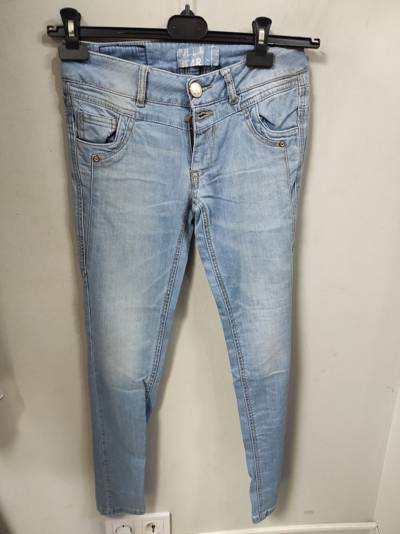

In [46]:
imgs[0]

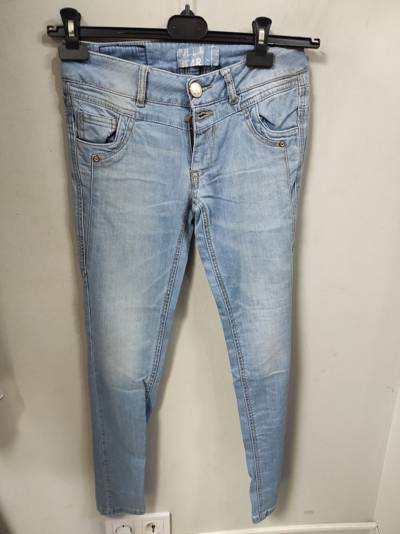

In [47]:
imgs[1]

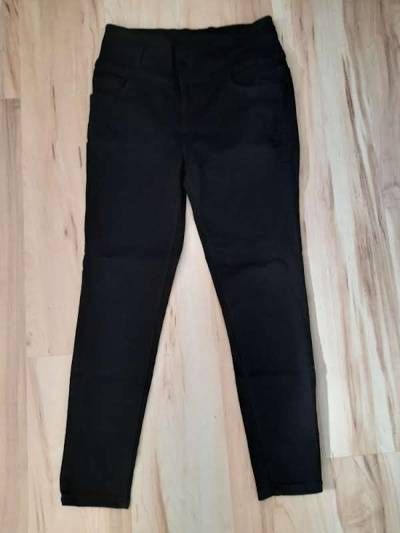

In [48]:
imgs[2]

#### Approach 2/3: Using Full Text-Search

In [128]:
tbl.create_fts_index("Description", replace=True)

In [139]:
rs = tbl.search(response, query_type="fts").limit(5).to_pandas()
rs

,filename,Description,vector,Title,Size,Category,Type,Gender,_score
0,0e20abb0-d56a-4f83-b254-9db70fb92794.jpg,"This shirt is a long-sleeved, black and grey s...","[-0.045025624, 0.041662034, -0.0006505165, 0.0...",Black and Grey Striped Shirt with Pink Accents,S,Tops,Casual,F,52.089787
1,10e51a41-3729-472e-b288-f3b8f895577a.jpg,This plaid shirt features a classic plaid patt...,"[-0.044541422, 0.05006024, -0.04257077, 0.0401...",Plaid shirt with embroidered hem,L,Tops,Casual,F,35.616638
2,bd289469-607c-45df-bad3-ed1057e277bf.jpg,This is a red and black plaid skirt with a cla...,"[-0.021971317, 0.12156065, -0.002515854, 0.034...",Red and Black Plaid Skirt,S,Skirts,Casual,F,34.096905
3,64c5d20e-7cec-4965-8c50-315389f44b22.jpg,These light washed blue jeans are distressed w...,"[-0.07545003, 0.05375045, 0.00353413, -0.01551...",Light Washed Blue Ripped Jeans,L,Jeans,Casual,M,29.116760
4,b0c03127-9dfb-4573-8934-1958396937bf.jpg,This red flannel plaid shirt has a classic and...,"[-0.03013145, 0.060508166, -0.03642542, 0.0301...",Red Flannel Plaid Shirt,S,Shirts,Casual,M,28.444168


In [140]:
imgs = show_image_from_response(rs)

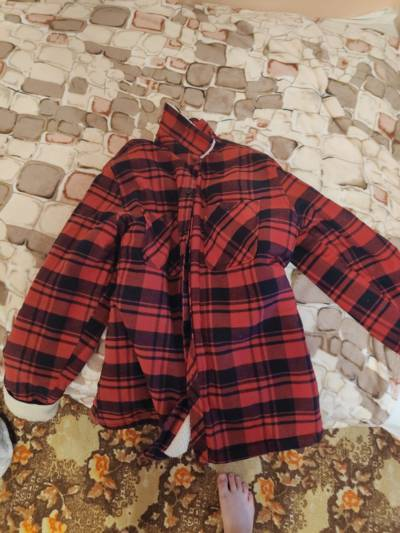

In [145]:
imgs[-1]

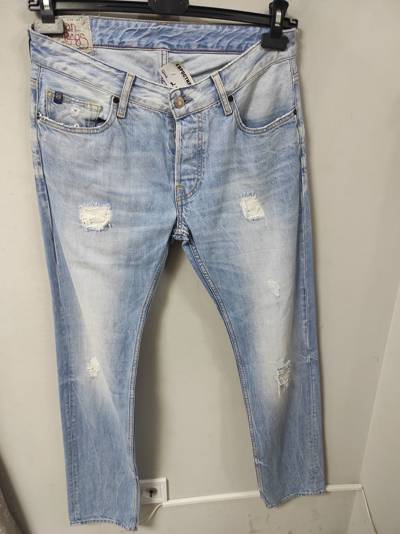

In [146]:
imgs[-2]

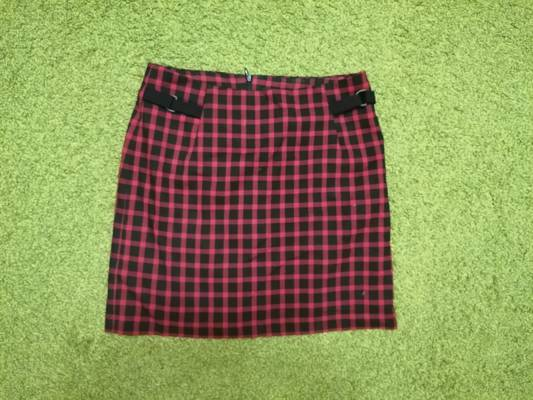

In [148]:
imgs[-3]

#### Approach 3/3: Using Hybrid search

In [153]:
from lancedb.rerankers import ColbertReranker

reranker = ColbertReranker(column="Description")
rs = tbl.search(response, query_type="hybrid").rerank(reranker=reranker).limit(5).to_pandas()
rs

Loading ColBERTRanker model colbert-ir/colbertv2.0
No device set
Using device cuda
No dtype set
Using dtype torch.float16
Loading model colbert-ir/colbertv2.0, this might take a while...
Linear Dim set to: {linear_dim} for downcasting


,filename,Description,vector,Title,Size,Category,Type,Gender,_relevance_score
0,0e20abb0-d56a-4f83-b254-9db70fb92794.jpg,"This shirt is a long-sleeved, black and grey s...","[-0.045025624, 0.041662034, -0.0006505165, 0.0...",Black and Grey Striped Shirt with Pink Accents,S,Tops,Casual,F,0.744141
1,10e51a41-3729-472e-b288-f3b8f895577a.jpg,This plaid shirt features a classic plaid patt...,"[-0.044541422, 0.05006024, -0.04257077, 0.0401...",Plaid shirt with embroidered hem,L,Tops,Casual,F,0.735352
2,300a4125-acec-46aa-b0b9-68b4b2142c70.jpg,These plaid shorts are a stylish and comfortab...,"[-0.002765015, 0.030705247, -0.010424565, -0.0...",Plaid Shorts,S,Pants,Casual,M,0.728516
3,bd289469-607c-45df-bad3-ed1057e277bf.jpg,This is a red and black plaid skirt with a cla...,"[-0.021971317, 0.12156065, -0.002515854, 0.034...",Red and Black Plaid Skirt,S,Skirts,Casual,F,0.699219
4,b0c03127-9dfb-4573-8934-1958396937bf.jpg,This red flannel plaid shirt has a classic and...,"[-0.03013145, 0.060508166, -0.03642542, 0.0301...",Red Flannel Plaid Shirt,S,Shirts,Casual,M,0.679199


In [154]:
imgs = show_image_from_response(rs)

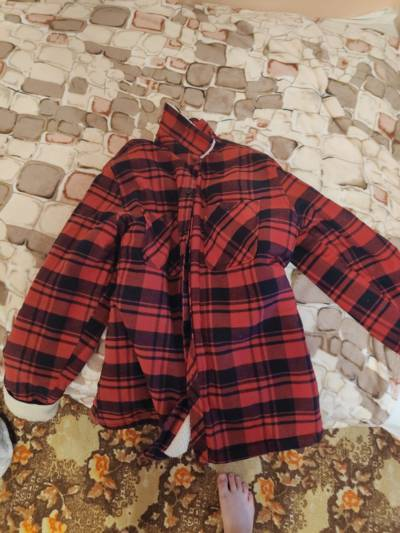

In [155]:
imgs[-1]

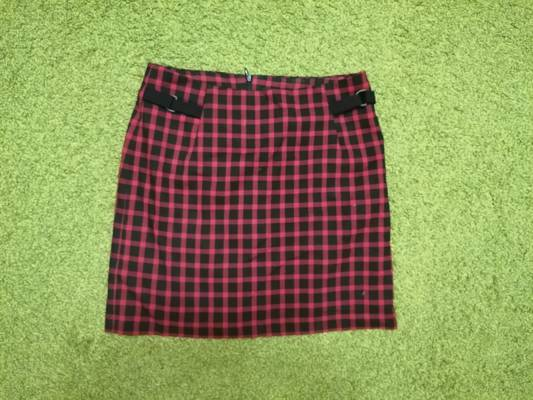

In [156]:
imgs[-2]

In [ ]:
#fin